In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy

In [2]:
data_dir = '../../output/'

In [3]:
demand = pd.read_csv(data_dir+'MQ_halfhour_consumption.csv')
demand.head()

,Half_Hour,Charger 1,Charger 2,Charger 3,Charger 4,Charger 5,Charger 6,Charger 7,Charger 8,Charger 9,...,Charger 13,Charger 14,Charger 15,Charger 16,Charger 17,Charger 18,Charger 19,Charger 20,Total,Hour
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.000000,0
1,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.000000,0
2,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.000000,1
3,1.5,41.466829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,41.466829,1
4,2.0,36.653462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,36.653462,2


In [4]:
demand_day = []
for i in demand.index:
    #print(i)
    if demand.Half_Hour[i] < 24:
        demand_day.append(demand.Total[i])
    else:
        demand_day[i-48] += demand.Total[i]

demand_day = np.array(demand_day)  
print(demand_day) # kW for each 30 min
len(demand_day)

[2892.86561003 2750.98688232 2469.71500417 2246.80333688 2039.59116176
 1772.5438897  1077.15499102  914.50342974  801.66960043  774.352521
  784.80309654  678.88692585  865.45695965 1389.92030962 1907.09340413
 2495.51379408 2568.88066926 4259.14210592 5069.71207555 5411.11323285
 5520.13589219 4775.03493068 4812.7433768  4341.67287044 4115.57779007
 3875.42517928 4013.74686409 4009.24811708 3903.08375064 3944.71372862
 3957.45646685 3988.0616788  4358.55213864 4316.30953014 4474.38060174
 4998.61182172 4874.62084429 4865.54139611 4710.68405845 4529.14892171
 4024.43311871 4106.35023316 3795.01726828 3770.42492931 3437.52324257
 3448.3721397  3086.19091391 2976.2270865 ]


48

In [91]:
Capacity = 5000 # kWh
Duration = 4 # hr
Power = Capacity / Duration # kW

In [92]:
x = np.arange(48)/2

In [93]:
Depot_Demand = cp.Variable(48, nonneg = True) 
Battery_Input = cp.Variable(48, nonneg = False) 
SOC = cp.Variable(49, nonneg = True) 
Maximum_Demand = cp.Variable(1) 

obj =  cp.Minimize(Maximum_Demand)

con_set = []

con_set.append( Depot_Demand == demand_day + Battery_Input )
con_set.append( SOC <= Capacity )
con_set.append( Battery_Input <= Power )
con_set.append( Battery_Input >= -Power)
for i in range(48):
    con_set.append( SOC[i] + Battery_Input[i] * 0.5 == SOC[i+1])
con_set.append( SOC[0] == SOC[48])
con_set.append( Depot_Demand <= Maximum_Demand)

In [94]:
prob = cp.Problem(obj, con_set)
prob.solve(solver = "GUROBI")

4168.873858

In [95]:
Maximum_Demand.value

array([4168.873858])

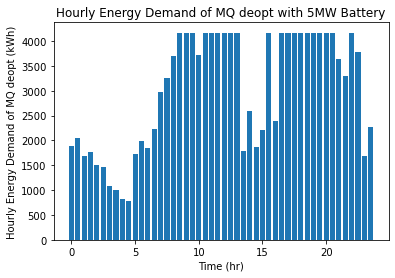

In [100]:
fig, ax = plt.subplots()
ax.bar(x, Depot_Demand.value, width = .4)
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Hourly Energy Demand of MQ deopt (kWh)")
ax.set_title("Hourly Energy Demand of MQ deopt with 5MW Battery")
ax.figure.savefig("../../fig/MQ_5MW_Battery.png", dpi = 200)

In [5]:
def battery_plotting(index, demand_before, demand_after, filename, depotname):
    
    demand_base = np.zeros(demand_before.shape)
    increase = np.zeros(demand_before.shape)
    decrease = np.zeros(demand_before.shape)
    
    for i in range(len(demand_before)):
        demand_base[i] = min(demand_before[i],demand_after[i])
        temp = demand_after[i] - demand_before[i]
        if temp >= 0:
            increase[i] = temp
        else:
            decrease[i] = -temp
    
    fig, ax = plt.subplots(figsize = (10,6))
    ax.bar(index, demand_base, width = 0.4, label = "Base Charger Demand")
    ax.bar(index, increase, width = 0.4, bottom = demand_base, label = "Increased Demand")
    ax.bar(index, decrease, width = 0.4, bottom = demand_base, label = "Decreased Demand")
    #ax.set_ylim(0, max(demand_before))
    ax.legend()
    ax.figure.savefig("../../fig/"+depotname+"_Battery_Comparison_"+ filename +".png", dpi = 200)

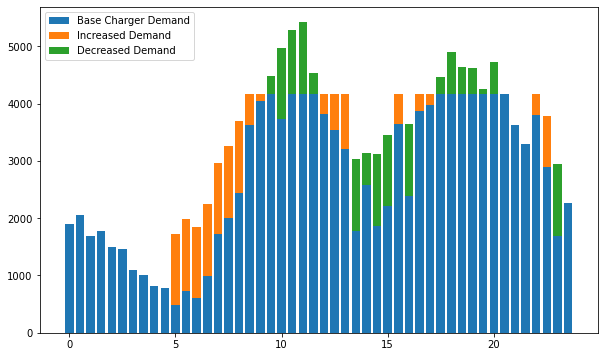

In [201]:
battery_plotting(x, demand_day, Depot_Demand.value, filename = "_Max")

In [202]:
# In this approach, opmitimizer will try it best to conduct overnight charging.
Depot_Demand2 = cp.Variable(48, nonneg = True) 
Battery_Input2 = cp.Variable(48, nonneg = False) 
SOC2 = cp.Variable(49, nonneg = True) 
Maximum_Demand2 = cp.Variable(1) 
Minimum_Demand2 = cp.Variable(1) 

obj2 =  cp.Minimize( sum(Depot_Demand2[8*2:22*2]) + 0.05 * (Maximum_Demand2 - Minimum_Demand2))

con_set2 = []

con_set2.append( Depot_Demand2 == demand_day + Battery_Input2 )
con_set2.append( SOC2 <= Capacity )
con_set2.append( Battery_Input2 <= Power )
con_set2.append( Battery_Input2 >= -Power)
for i in range(48):
    con_set2.append( SOC2[i] + Battery_Input2[i] * 0.5 == SOC2[i+1])
con_set2.append( SOC2[0] == SOC2[48])
con_set2.append( Depot_Demand2 <= Maximum_Demand2)
con_set2.append( Depot_Demand2 >= Minimum_Demand2)

In [203]:
prob2 = cp.Problem(obj2, con_set2)
prob2.solve(solver = "GUROBI")

101993.92631807501

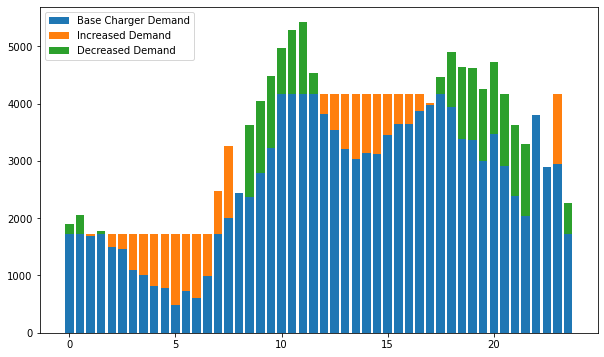

In [204]:
battery_plotting(x, demand_day, Depot_Demand2.value, filename = "Inte")

In [4]:
def MQ_opti(Capacity, depotname):
    result = []
    for i in Capacity:
        Duration = 4 # hr
        Power = i / Duration # kW

        # In this approach, opmitimizer will try it best to conduct overnight charging.
        Depot_Demand2 = cp.Variable(48, nonneg = True) 
        Battery_Input2 = cp.Variable(48, nonneg = False) 
        SOC2 = cp.Variable(49, nonneg = True) 
        Maximum_Demand2 = cp.Variable(1) 
        Minimum_Demand2 = cp.Variable(1) 

        obj2 =  cp.Minimize(Maximum_Demand2 - 0.05 * Minimum_Demand2)

        con_set2 = []

        con_set2.append( Depot_Demand2 == demand_day + Battery_Input2 )
        con_set2.append( SOC2 <= i )
        con_set2.append( Battery_Input2 <= Power )
        con_set2.append( Battery_Input2 >= -Power)
        for j in range(48):
            con_set2.append( SOC2[j] + Battery_Input2[j] * 0.5 == SOC2[j+1])
        con_set2.append( SOC2[0] == SOC2[48])
        con_set2.append( Depot_Demand2 <= Maximum_Demand2)
        con_set2.append( Depot_Demand2 >= Minimum_Demand2)

        prob2 = cp.Problem(obj2, con_set2)
        prob2.solve(solver = "GUROBI")

        result.append(Maximum_Demand2.value[0])
        battery_plotting(x, demand_day, Depot_Demand2.value, filename = "Inte_" + str(i), depotname = depotname)
        
    return result

Academic license - for non-commercial use only - expires 2022-10-27
Using license file /Users/shentianxiao/gurobi.lic


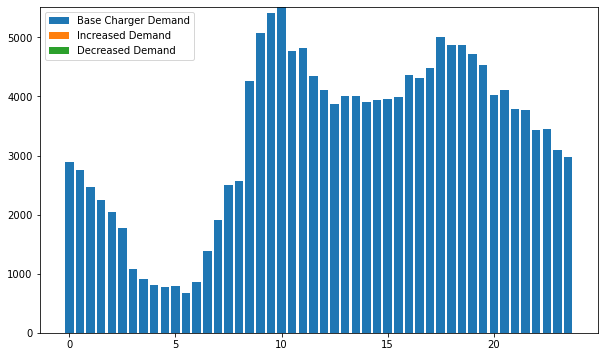

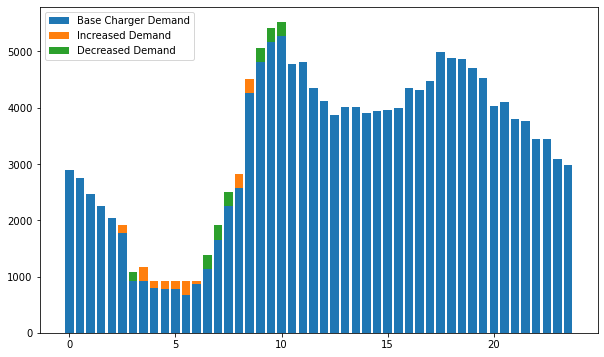

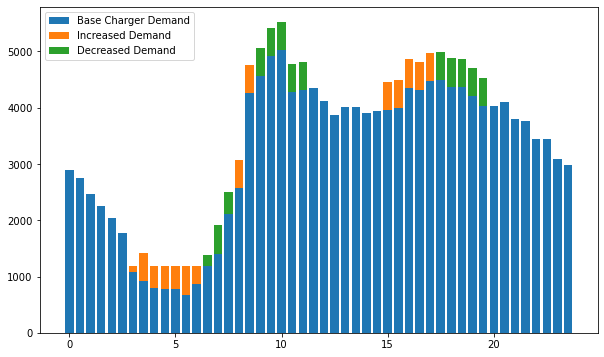

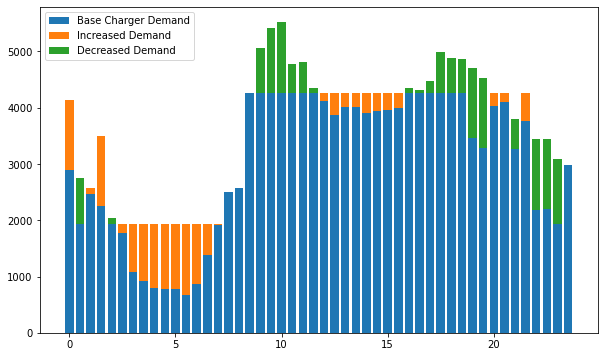

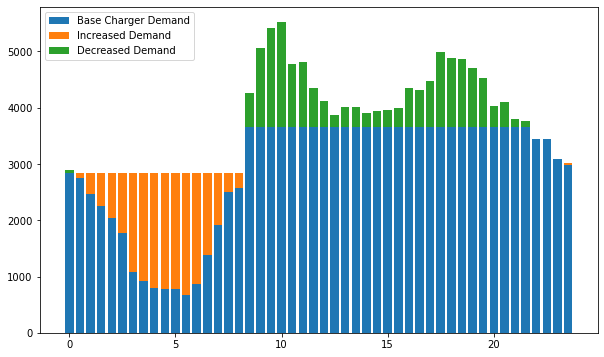

In [7]:
Capacity = [0, 1000 ,2000 ,5000 ,10000]
x = np.arange(48)/2

result = MQ_opti(Capacity, "MQ")

In [8]:
result

[5520.135892193251,
 5270.135892193251,
 5020.135892193251,
 4270.135892193251,
 3660.0349230411443]

In [9]:
demand = pd.read_csv(data_dir+'KB_halfhour_consumption.csv')

demand_day = []
for i in demand.index:
    #print(i)
    if demand.Half_Hour[i] < 24:
        demand_day.append(demand.Total[i])
    else:
        demand_day[i-48] += demand.Total[i]

demand_day = np.array(demand_day)  
print(demand_day) # kW for each 30 min
len(demand_day)

[1893.47821892 2056.23077042 1691.95659841 1769.43813053 1504.44034214
 1465.6135117  1089.13440791 1010.74114072  821.19549401  783.85356804
  478.01619654  736.03093031  604.19589658  989.8107501  1717.17788103
 2004.98503368 2442.12115609 3617.21545479 4046.30431301 4478.97240024
 4974.62791186 5280.01636803 5418.87385818 4526.46141429 3820.19283878
 3531.13852434 3214.45637227 3034.21460573 3134.67138023 3112.51363093
 3454.09594097 3649.38196326 3636.94125671 3860.69580719 3966.70831354
 4465.49691307 4890.401732   4632.83257538 4616.94595866 4249.31817145
 4723.60652315 4165.32780802 3632.20962183 3296.14062191 3801.92089718
 2891.67870805 2936.28640902 2266.69933736]


48

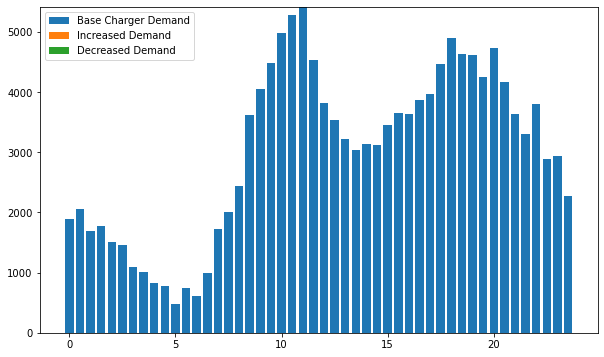

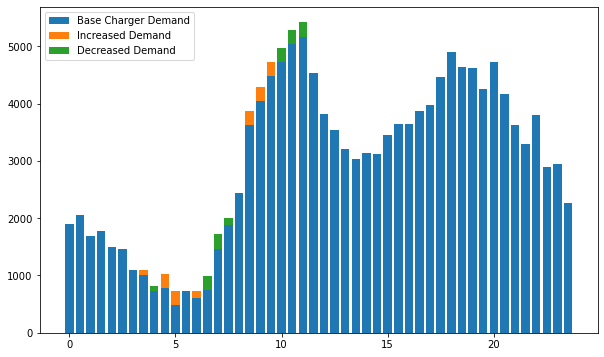

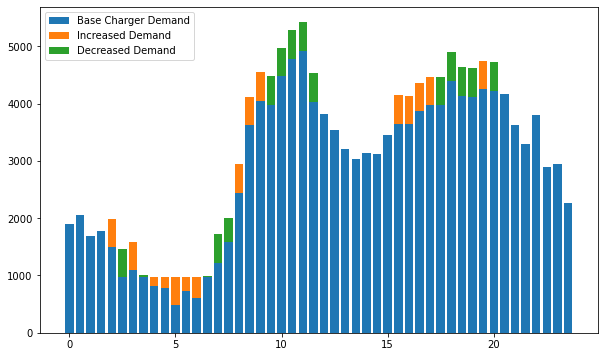

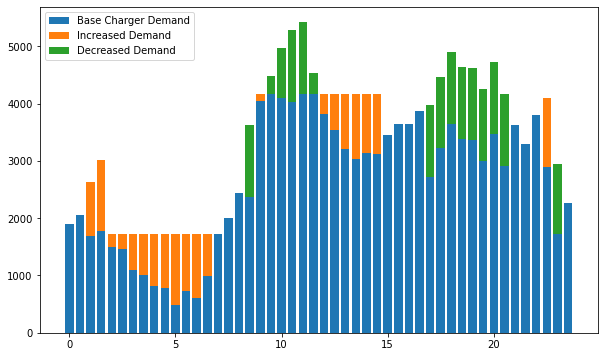

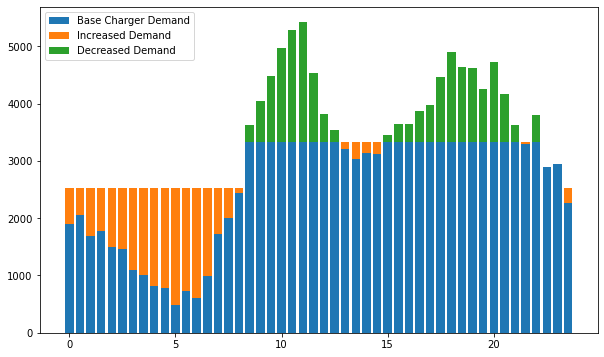

In [10]:
Capacity = [0, 1000 ,2000 ,5000 ,10000]
x = np.arange(48)/2

result = MQ_opti(Capacity, "KB")

In [11]:
result

[5418.873858184559,
 5168.873858184559,
 4918.873858184559,
 4168.873858184559,
 3329.7029706069025]